# Analyse results from Pypsa-Earth

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https://pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Own setting

In [2]:
# Check config.yaml - run:
name = ""


# Check config.yaml - scenario: 
clusters = 8
opts = "Co2L0.4-144H" 


## Import packages

In [3]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy

## Path settings

In [4]:
nc_file_name = "elec_s_" + str(clusters) + "_ec_lcopt_" + opts + ".nc"
scenario_name = name 
scenario_subpath = scenario_name + "/" if scenario_name else ""

# Network file
results_path = "results/" + scenario_name + "/networks/" + nc_file_name
network_path = "networks/" + scenario_name + "/elec.nc"
# Country shape file
regions_onshore_path = "resources/" + scenario_name + "/shapes/country_shapes.geojson"
# Renewable profile file
solar_path = "resources/" + scenario_name + "/renewable_profiles/profile_solar.nc"
onwind_path = "resources/" + scenario_name + "/renewable_profiles/profile_onwind.nc" 

## Energy system analysis setup - power and energy generation

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
n = pypsa.Network(results_path)
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec_s_8_ec_lcopt_Co2L0.4-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Data import check

Country check

Text(0.5, 1.0, 'CM')

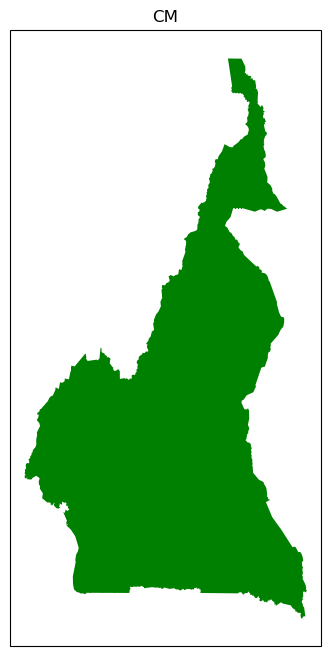

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

Component check

In [7]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 25 entries
Component 'Carrier' has 17 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 6 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 41 entries
Component 'Load' has 9 entries
Component 'Generator' has 30 entries
Component 'StorageUnit' has 1 entries
Component 'Store' has 17 entries


Snapshot check

In [8]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)
Time steps: 8760


## Analyse energy system

Analyse the current capacity of the energy system - map view

/home/alex/anaconda3/envs/pypsa-analyse/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


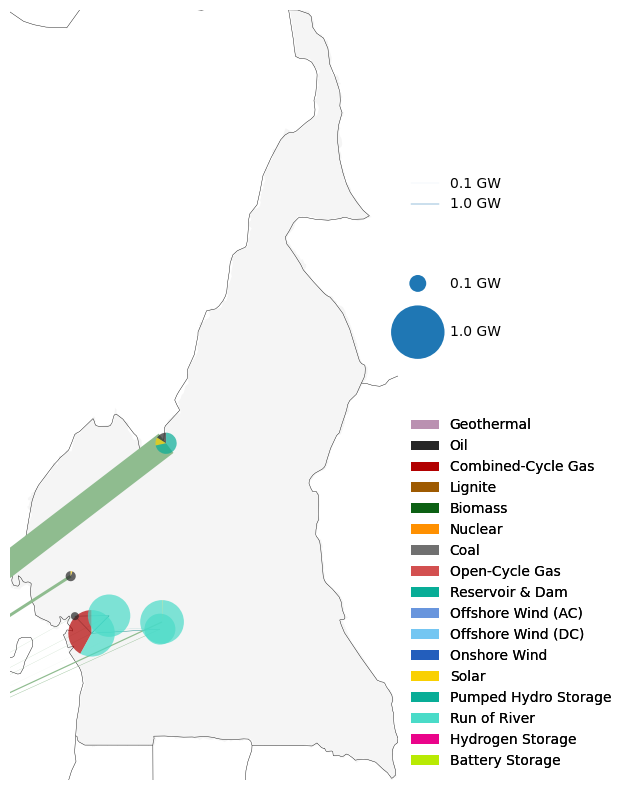

In [9]:
# Scale settings
bus_scale = 3e3 
line_scale = 3e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

#n.carriers.drop("Load", inplace=True)
#n.carriers.drop("export", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[(n.generators.carrier != "load") & (n.generators.carrier != "export")].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analyse the current generation capacity of the energy system - pie chart view

Text(0.5, 1.0, 'Generator Capacity by Carrier')

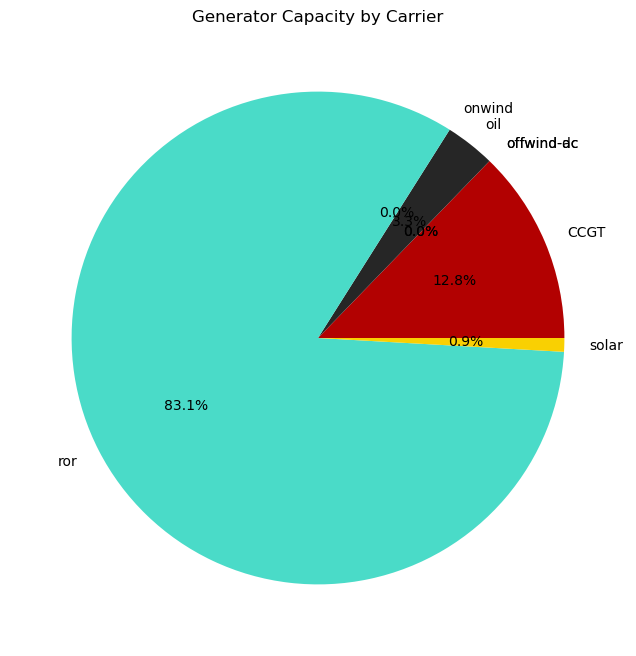

In [10]:
generator_capacity_by_carrier = n.generators[(n.generators.carrier != "load") & (n.generators.carrier != "export")].groupby(["carrier"]).p_nom.sum()
plt.figure(figsize=(8, 8))
plt.pie(generator_capacity_by_carrier, labels=generator_capacity_by_carrier.index, autopct='%1.1f%%', colors=n.carriers[n.carriers.index.isin(generator_capacity_by_carrier.index)].color.reindex(generator_capacity_by_carrier.index))
plt.title("Generator Capacity by Carrier")

Analyse the current gernation capacity of the energy system - tabular view

In [11]:
generator_capacity_by_carrier/1e3 # in GW

carrier
CCGT          0.200000
offwind-ac    0.000000
offwind-dc    0.000000
oil           0.051380
onwind        0.000000
ror           1.303000
solar         0.014031
Name: p_nom, dtype: float64

In [30]:
n.generators_t.p

Generator,1 onwind,1 ror,1 solar,11 onwind,11 solar,13 onwind,13 ror,13 solar,19 CCGT,19 offwind-ac,...,26 onwind,26 solar,3 offwind-ac,3 offwind-dc,3 oil,3 onwind,3 solar,6 onwind,6 ror,6 solar
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000008,54.096516,0.0,0.000012,0.0,0.000007,45.352310,0.0,111.188628,0.000003,...,0.000000e+00,0.0,0.000003,0.000004,13.200012,0.000135,0.0,1.792670e-06,89.548634,0.0
2013-01-01 01:00:00,0.000007,54.034831,0.0,0.000013,0.0,0.000004,45.336577,0.0,116.711163,0.000003,...,0.000000e+00,0.0,0.000002,0.000004,13.203284,0.000116,0.0,1.626655e-06,89.361958,0.0
2013-01-01 02:00:00,0.000005,53.989935,0.0,0.000009,0.0,0.000002,45.341196,0.0,117.513210,0.000003,...,0.000000e+00,0.0,0.000002,0.000004,13.205492,0.000100,0.0,7.811561e-07,89.356637,0.0
2013-01-01 03:00:00,0.000004,54.191492,0.0,0.000005,0.0,0.000002,45.408125,0.0,121.021198,0.000003,...,0.000000e+00,0.0,0.000001,0.000003,13.206784,0.000093,0.0,0.000000e+00,89.339096,0.0
2013-01-01 04:00:00,0.000003,54.088071,0.0,0.000000,0.0,0.000002,45.458893,0.0,163.561362,0.000003,...,0.000000e+00,0.0,0.000000,0.000003,13.214211,0.000084,0.0,0.000000e+00,89.194747,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.000005,50.986923,0.0,0.000016,0.0,0.000012,47.393645,0.0,192.402507,0.000014,...,1.758433e-06,0.0,0.000012,0.000012,13.981382,0.000054,0.0,7.089948e-06,91.039743,0.0
2013-12-31 20:00:00,0.000006,51.029836,0.0,0.000014,0.0,0.000016,47.402705,0.0,191.281733,0.000010,...,1.180036e-06,0.0,0.000010,0.000010,13.980902,0.000060,0.0,5.960611e-06,90.934501,0.0
2013-12-31 21:00:00,0.000006,51.018876,0.0,0.000011,0.0,0.000018,47.339583,0.0,188.814429,0.000009,...,7.952431e-07,0.0,0.000007,0.000009,13.977853,0.000065,0.0,3.792984e-06,90.576615,0.0


Analyse the future capacity of the energy system - map view

/home/alex/anaconda3/envs/pypsa-analyse/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


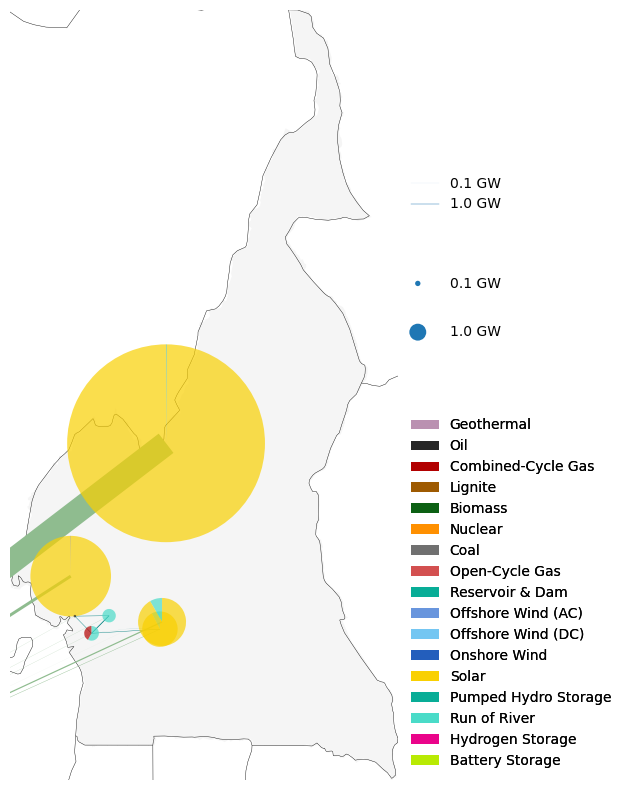

In [12]:
bus_scale = 3e4

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[(n.generators.carrier != "load") & (n.generators.carrier != "export")].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Calculate emissions of future energy system

In [13]:
#ToDo: Not fully correct - double check
co2_emissions = pd.DataFrame(data=n.carriers[["co2_emissions", "nice_name"]]).set_index("nice_name").squeeze().rename_axis("carrier")

energy_production = n.statistics.energy_balance().Generator.droplevel(1).drop(["load", "export"], errors="ignore")

co2_emissions_technology = energy_production * co2_emissions.loc[energy_production.index]
co2_emissions_technology

carrier
Combined-Cycle Gas    75636.909034
Offshore Wind (AC)        0.000000
Offshore Wind (DC)        0.000000
Oil                    5683.151533
Onshore Wind              0.000000
Run of River              0.000000
Solar                     0.000000
dtype: float64

In [14]:
co2_emissions_sum = co2_emissions_technology.sum()
co2_emissions_sum

81320.06056715104

In [15]:
n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,800000.0,0.000029,primary_energy,NaN,co2_emissions


In [16]:
# Step 1: Create the links_energy DataFrame with "carrier" and "bus0" columns
links_energy = n.links[["carrier", "bus0"]]

# Step 2: Filter only rows where "carrier" contains 'export'
links_energy = links_energy[links_energy["carrier"].str.contains("export", case=False, na=False)]

# Step 3: Calculate the energy sum for indices that contain 'export'
export_energy = n.links_t.p0.sum()
export_energy = export_energy[export_energy.index.str.contains("export", case=False, na=False)]

# Step 4: Map the energy sum to the correct rows in links_energy based on the index
links_energy["energy"] = links_energy.index.map(export_energy)

# Step 5: Group by "bus0" and "carrier" and sum the "energy" values
links_energy_grouped = links_energy.groupby(["bus0", "carrier"], as_index=False)["energy"].sum()

# Display the result
links_energy_grouped


,bus0,carrier,energy
0,1,export,8.264902e+05
1,11,export,1.722281e+05
2,13,export,2.835609e+06
3,19,export,5.160351e+05
4,20,export,7.667714e+06
5,26,export,4.836145e+05
6,3,export,1.119915e+08
7,6,export,5.068016e+05
8,Electricity export bus,export,0.000000e+00


/home/alex/anaconda3/envs/pypsa-analyse/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


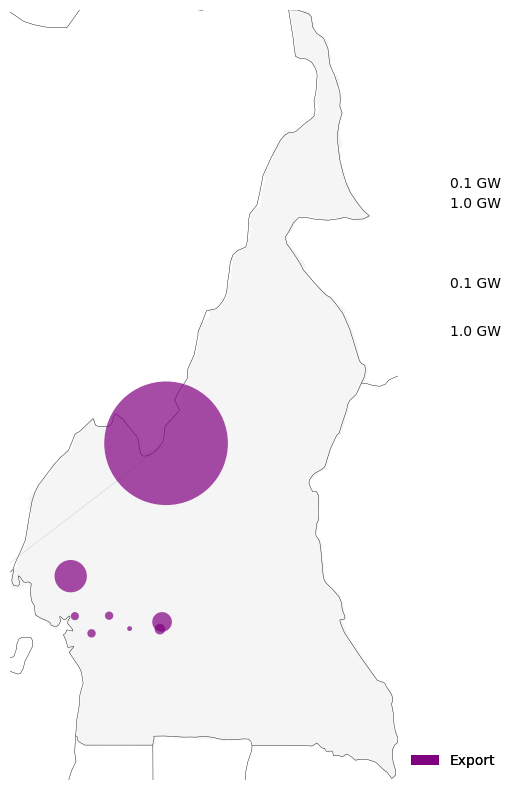

In [17]:
# Set color
n.carriers.loc["export", "color"] = "#800080"
n.carriers.loc["export", "nice_name"] = "Export"

# Scale settings
bus_scale = 1e8
line_scale = 3e5

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
export = links_energy_grouped[links_energy_grouped.carrier == "export"].groupby(["bus0", "carrier"]).energy.sum()
buses = pd.concat([export])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color.loc["export"],
    n.carriers.nice_name.loc["export"],
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analys the future generation capacity expansion of the energy system - bar chart

<Axes: title={'center': 'Generator capacity expansion in GW'}, xlabel='carrier'>

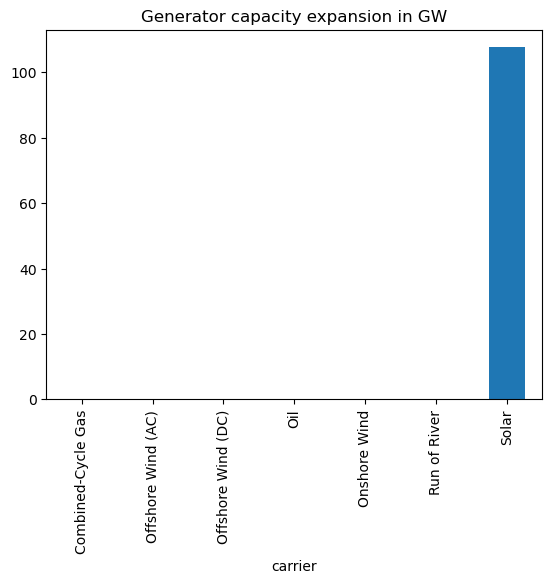

In [18]:
generation_capacity_expansion = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)-n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

Plot the future generation capacity expansion of the energy system - tabular chart

In [19]:
generation_capacity_expansion # In GW

carrier
Combined-Cycle Gas      0.000000
Offshore Wind (AC)           NaN
Offshore Wind (DC)           NaN
Oil                     0.000000
Onshore Wind                 NaN
Run of River            0.000000
Solar                 107.629821
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

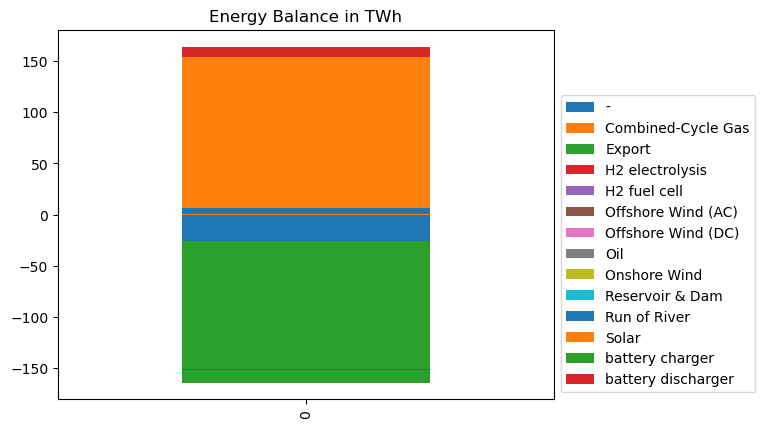

In [20]:
fig, ax = plt.subplots()
color_setting = n.carriers.set_index(n.carriers.nice_name)
energy_balance = n.statistics.energy_balance().loc[:, :, "AC"].groupby("carrier").sum().div(1e6).to_frame().T
energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh")
n.carriers[n.carriers.index.isin(generator_capacity_by_carrier.index)].color.reindex(generator_capacity_by_carrier.index)

ax.legend(bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

Analyse the future energy generation of the energy system - tabular view

In [21]:
n.statistics.energy_balance()/1e6 # In TWh

component    carrier             bus_carrier
Generator    Combined-Cycle Gas  AC             4.044754e-01
             Offshore Wind (AC)  AC             9.491258e-08
             Offshore Wind (DC)  AC             1.446975e-07
             Oil                 AC             2.291593e-02
             Onshore Wind        AC             3.807639e-07
             Run of River        AC             5.266852e+00
             Solar               AC             1.482282e+02
Store        Battery Storage     battery        1.062261e-16
             Export              export        -9.313226e-16
             Hydrogen Storage    H2             7.389644e-19
StorageUnit  Reservoir & Dam     AC             1.539055e-01
Load         -                   AC            -2.621065e+01
             Export              export        -1.250000e+02
Link         Export              AC            -1.250000e+02
                                 export         1.250000e+02
             H2 electrolysis     AC     

## Analyse pv and wind potential - map view

In [22]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot pv energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


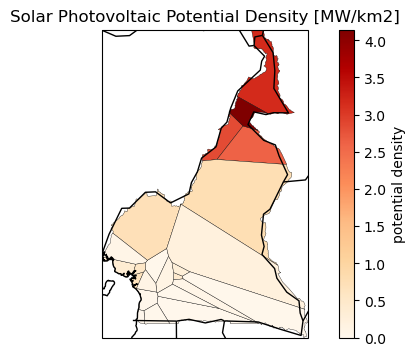

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot wind energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


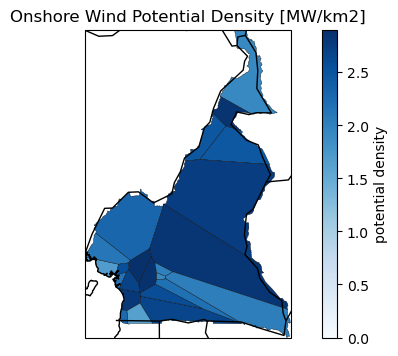

In [24]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Levelized cost of electricity

In [25]:
# Calculation levelzied cost of electricity in €/MWh based on overall costs and electricity generation
# n.statistics.market_value() ?
lcoe = n.objective/n.statistics.energy_balance().Generator.sum()
lcoe 

40.657863623913826

In [26]:
# Calculation levelzied cost of electricity in €/MWh based on overall costs and electricity demand
lcoe = n.objective/n.statistics.energy_balance().Load.sum()*(-1)
lcoe 

41.387017347967664